In [1]:
import math
from simtk import unit
from simtk.openmm import openmm as mm
from simtk.openmm import app as app
from openmmtools import testsystems, states, mcmc
from openmmtools import multistate
testsystem = testsystems.AlanineDipeptideExplicit()
import os
import tempfile
import numpy as np
import mdtraj as md
import copy

from pylab import *
from math import pi
import random

In [4]:
class Replica(object):
    def __init__(self, system, topology, solute, solvent, device_id):
        self.system = system
        self.topology = topology
        
        self.device_id = device_id
        
        self.solute = solute
        self.solvent = solvent
        
        self.temps = {'solvent': 300*unit.kelvin, 'solute': 1200*unit.kelvin}
        self.frictions = {'solvent': 25 / unit.picosecond, 'solute': 25 / unit.picosecond}
        self.time_step = 1.0 * unit.femtosecond
        self.pressure = 1 * unit.atmospheres
        
        
        self.vanilla_forces = []
        #put each force in sperae group
        for force_index, force in enumerate(self.system.getForces()):
            
            #save the nonbonded force to manipulate later
            if isinstance(force, mm.NonbondedForce):
                self.nonbonded_force = force
            
            force.setForceGroup(force_index)
            self.vanilla_forces.append(force_index)
            
        self.prot_force_idx, self.water_force_idx = self.add_solv_solu_forces()
        
        self.simulation = self.build_simulation()
            
    def add_solv_solu_forces(self):

        protien = copy.deepcopy(self.nonbonded_force)
        mute_nonbonded(protien, solvent)
        self.system.addForce(protien)
        protein_force_idx = max(self.vanilla_forces)+1
        protien.setForceGroup(protein_force_idx)

        water_water = copy.deepcopy(self.nonbonded_force)
        mute_nonbonded(water_water, solute)
        system.addForce(water_water)
        water_force_idx = max(self.vanilla_forces)+2
        water_water.setForceGroup(water_force_idx)

        return(protein_force_idx, water_force_idx)
    
    def build_simulation(self):

        integrator = mm.NoseHooverIntegrator(self.time_step)
        integrator.addSubsystemThermostat(self.solvent, [], self.temps['solvent'],
                                          self.frictions['solvent'], self.temps['solvent'],
                                          self.frictions['solvent'], 3,3,3)
        
        integrator.addSubsystemThermostat(self.solute, [], self.temps['solute'],
                                          self.frictions['solute'], self.temps['solute'],
                                          self.frictions['solute'], 3,3,3)

        integrator.setIntegrationForceGroups(set(self.vanilla_forces)) 


        integrator.setConstraintTolerance(0.00001)

        platform = mm.Platform.getPlatformByName('CUDA')
        properties = {'CudaPrecision': 'mixed', 'CudaDeviceIndex': self.device_id}

        sim = app.Simulation(self.topology, self.system, integrator, platform, properties)

        return {'sim': sim, 'integrate': integrator}
    
    def get_energy(self, sub_sys='all'):
        sub_systems = {'solvent': [self.water_force_idx], 'solute': [self.prot_force_idx], 'all': self.vanilla_forces}
        index = sub_systems[sub_sys]
        return self.simulation['sim'].context.getState(getEnergy=True, groups=set(index)).getPotentialEnergy()
    
    def get_interaction_energy(self, interaction, positions=None):
        
        if positions is not None:
            current_pos = self.simulation['sim'].context.getState(getPositions=True).getPositions()
            self.simulation['sim'].context.setPositions(positions)
        
        if interaction == 'ww':
            energy = self.get_energy('solvent')
        elif interaction == 'pp':
            energy = self.get_energy('solute')
        elif interaction == 'pw':
            energy = self.get_energy('all')-self.get_energy('solvent')-self.get_energy('solute')
        else:
            raise ValueError('Unkown interaction. Use: pp, pw, ww')
        
        #restore positions of context
        if positions is not None:
            self.simulation['sim'].context.setPositions(current_pos)
            
        return energy
            
    def get_solute_temp(self):
        return self.simulation['integrate'].getTemperature(1)
    
    def get_solvent_temp(self):
        return self.simulation['integrate'].getTemperature(0) 
        
    def set_solute_temp(self, temp):
        self.simulation['integrate'].setTemperature(temp, 1)
        
    def set_solvent_temp(self, temp):
        self.simulation['integrate'].setTemperature(temp, 0)   
        
        
def mute_nonbonded(force, atoms):
    for atom in atoms:
        force.setParticleParameters(atom, 0.0, 1.0, 0.0)           

    
    
        

In [5]:
# CONSTANTS #
kB = 0.008314472471220214 * unit.kilojoules_per_mole/unit.kelvin

class REST(object):
    def __init__(self, system , topo, positions, solute, solvent, tempratures):
        self.temps = tempratures
        self.positions = positions
        self.replicas = []
        self.pos = positions
        for t in self.temps:
            replica = Replica(system, topo, solute, solvent, device_id='0')
            replica.set_solvent_temp(t)
            replica.set_solute_temp(t)
            self.replicas.append(replica)
            
    def serial_simulation(self):
        #init all reps
        for i, rep in enumerate(self.replicas):
            sim = rep.simulation['sim']
            sim.context.setPositions(self.positions)
            print('Minimizing replica {}'.format(i))
            sim.minimizeEnergy()
            sim.context.setVelocitiesToTemperature(300*unit.kelvin)
            print('Equilibrating replica {}'.format(i))
            sim.step(10)
            
            sim.reporters.append(app.StateDataReporter('./ala_log_{}'.format(i), 50, step=True,
                                                   potentialEnergy=True, volume=True, temperature=True, progress=True,
                                                   remainingTime=True, speed=True, totalSteps=1000, separator='\t'))
            sim.reporters.append(app.DCDReporter('ala_{}.dcd'.format(i), 50))
        
        for step in range(100):
            #propogate all reps
            for i, rep in enumerate(self.replicas):  
                sim = rep.simulation['sim']
                
                print('Running production for replica {}'.format(i))
                sim.step(100)
                print('Done!')

            #swap reps
            for i, rep in enumerate(self.replicas):  
                if i != len(self.replicas)-1:
                    delta = self.get_acceptance_probability(rep, self.replicas[i+1])
                    if metrop(delta):
                        print('Swap rep{} for rep{}'.format(i, i+1))
                        self.swap_reps(rep, self.replicas[i+1])
            
    def get_acceptance_probability(self, rep1, rep2):
        
        bn = 1/(kB*rep1.get_solute_temp())
        bm = 1/(kB*rep2.get_solute_temp())
        
        Xm = rep2.simulation['sim'].context.getState(getPositions=True).getPositions()
        
        #Some optimizations could be done here to reduce the number
        #of times postions are set and energies are calculated
        EpXn = rep1.get_interaction_energy('pp') #positions Xn are implicit
        EpwXn = rep1.get_interaction_energy('pw') #positions Xn are implicit
        
        EpXm = rep1.get_interaction_energy('pp', Xm)
        EpwXm = rep1.get_interaction_energy('pw', Xm)
        
        Xm_terms = EpXm + 0.5*EpwXm
        Xn_terms = EpXn + 0.5*EpwXn
        
        
        print('@@@@@@@@@@')
        print(EpXm, 0.5*EpwXm)
        print(EpXn, 0.5*EpwXn)
        
        print('###')
        print(Xm_terms)
        print(Xn_terms)
        print((bn - bm))
        
        
        delta = (bn - bm)*(Xm_terms-Xn_terms)
        
        return delta
    
    def swap_reps(self, rep1, rep2):
        #should swap box size for NPT
        Xm = rep2.simulation['sim'].context.getState(getPositions=True).getPositions()
        rep1.simulation['sim'].context.setPositions(Xm)
             
            
def metrop(delta):
    if delta <= 0:
        print('**100 percent')
        return True
    else:
        print('//////')
        prob = np.exp(-delta)
        print('{}percent'.format(prob*100))
        ##THE DISTRIBUTION OF THIS RANDOM NUMBER IS IMPORTANT
        if prob > random.random():
            return True
        else:
            return False

In [7]:
system = testsystem.system
topo = testsystem.topology
positions = testsystem.positions

##Needs to be auto detected
solute = list(range(22))
solvent = list(range(22, 2269))

rest = REST(system, topo, positions, solute, solvent, [300, 350, 400])

In [8]:
rest.serial_simulation()

Minimizing replica 0
Equilibrating replica 0
Minimizing replica 1
Equilibrating replica 1
Minimizing replica 2
Equilibrating replica 2
Running production for replica 0
Done!
Running production for replica 1
Done!
Running production for replica 2
Done!
@@@@@@@@@@
-132.7008199040102 kJ/mol -130.44089806033477 kJ/mol
-118.0646405816438 kJ/mol -170.63309073508955 kJ/mol
###
-263.14171796434493 kJ/mol
-288.6977313167333 kJ/mol
0.05727248214950087 mol/kJ
//////
23.13886953877644percent
Swap rep0 for rep1
@@@@@@@@@@
109.74399542808533 kJ/mol -17350.768766223075 kJ/mol
177.54556739330292 kJ/mol -17063.368025807227 kJ/mol
###
-17241.02477079499 kJ/mol
-16885.822458413924 kJ/mol
0.04295436161212568 mol/kJ
**100 percent
Swap rep1 for rep2
Running production for replica 0
Done!
Running production for replica 1
Done!
Running production for replica 2
Done!
@@@@@@@@@@
-133.72879409424786 kJ/mol -97.65833996915171 kJ/mol
-118.66331008813563 kJ/mol -161.68524022114877 kJ/mol
###
-231.38713406339957 kJ/

KeyboardInterrupt: 

In [ ]:
##Analysis

In [5]:
traj = md.load_dcd('./ala.dcd', testsystem.mdtraj_topology)

In [6]:
#atoms, bonds = traj.topology.to_dataframe()
#atoms

In [7]:
psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
angles = md.compute_dihedrals(traj, [phi_indices, psi_indices])

(-3.141592653589793, 3.141592653589793)

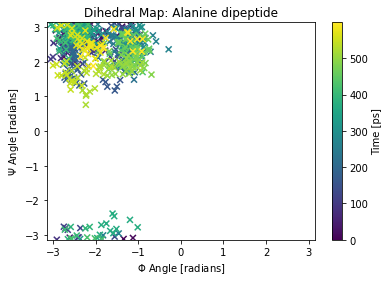

In [8]:
figure()
title('Dihedral Map: Alanine dipeptide')
scatter(angles[:, 0], angles[:, 1], marker='x', c=traj.time)
cbar = colorbar()
cbar.set_label('Time [ps]')
xlabel(r'$\Phi$ Angle [radians]')
xlim(-pi, pi)
ylabel(r'$\Psi$ Angle [radians]')
ylim(-pi, pi)